Discussed this assignment with Sang Hoon Kim, Hyun In Park, and Heeseung Hwang.

**Preliminary setup:**

In [1]:
import random
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

np.random.seed(25025)
data = scipy.io.loadmat("IMAGES_RAW.mat")
images = data["IMAGESr"]

In [2]:
def sample_random_square_patches(image, num, width):
    '''
    Selects random patches of images
    (Edited the original code so that 12*12 patches are "flattened" to 144*1 dimension before being returned)
    '''
    patches = np.zeros([width, width, num])
    
    for k in range(num):
        
        i, j = random.sample(range(image.shape[0] - width), 2)
        patches[:, :, k] = image[i:i + width, j:j + width]
    
    return np.reshape(patches, (144, num))

**Part (a)(ii):**

Loss function: $C(V)=\frac{1}{2}\sum^b_{i=1}|X_i-V\alpha_i|^2$  
  
$\frac{\partial C(V)}{\partial V_k}=-2\times\frac{1}{2}\sum^b_{i=1}[|X_i-V\alpha_i|\times\frac{X_i-V\alpha_i}{|X_i-V\alpha_i|}\times\frac{\partial}{\partial V_j}(X_i-V\alpha_i)]=-\sum^b_{i=1}(X_i-V\alpha_i)\frac{\partial}{\partial V_j}(X_i-V\alpha_i)$  
  
$=-\sum^b_{i=1}(X_i-V\alpha_i)\frac{\partial}{\partial V_j}(\alpha_{ij}V_j)=-\sum^b_{i=1}(X_i-V\alpha_i)\alpha_{ij}$  
($\because$ every column of $V\alpha_i$ except $\alpha_{ij}V_j$ is constant in $V_j$.)

Then, the gradient loss is:  

$\nabla C(V)=(\frac{\partial C(V)}{\partial V_1}\space...\space\frac{\partial C(V)}{\partial V_L}) = (-\sum^b_{i=1}(X_i-V\alpha_i)\alpha_{i1}\space...\space-\sum^b_{i=1}(X_i-V\alpha_i)\alpha_{iL})$  

$=-(\sum^b_{i=1}(X_i-V\alpha_i)\alpha_{i1}\space...\space\sum^b_{i=1}(X_i-V\alpha_i)\alpha_{iL})$  

$=-[(X_1\space...\space X_b)(\alpha_1\space...\space\alpha_b)^T-(V\alpha_1\space...\space V\alpha_b)(\alpha_1\space...\space\alpha_b)^T]$  

$=-[(X_1\space...\space X_b) - (V\alpha_1\space...\space V\alpha_b)](\alpha_1\space...\space\alpha_b)^T$  

$=-[(X_1\space...\space X_b)-V(\alpha_1\space...\space\alpha_b)](\alpha_1\space...\space\alpha_b)^T=-(X-VA)A^T$

Thus, for every SGD iteration step, we update the codebook by $V_{new} = V_{old}-\delta\nabla C(V)$.  

After that, we normalize each filter in the codebook by $V_i^{new}\Leftarrow \frac{V_i^{new}}{|V_i^{new}|}\space\space\forall i$

**Part (b):**

In here and part (c), I used 50,000 sample patches (5,000 randomly chosen from each image) and codebook size of 200. Thus, with the batch size of 20, there will be 2,500 batches (i.e. 2,500 iterations / updates).  
I implemented a function that runs SGD and executed the process here. Results are examined in part (c) and (d).

In [3]:
def sparse_sgd(patches, delta):

    rng = np.random.default_rng()
    codebook_ind = rng.choice(50000, size = 200, replace = False)
    codebook = patches[:, codebook_ind]
    
    record, raw_record, fnorm = [codebook[:, :]], [codebook[:, :]], []
    
    for i in range(2500):

        batch = patches[:, i * 20:i * 20 + 20]
    
        lasso = Lasso(fit_intercept = False, copy_X = True, alpha = 0.001)
        alpha = lasso.fit(codebook, batch).coef_.T
        
        gradient = (-1) * np.matmul(batch - np.matmul(codebook, alpha), alpha.T)
        codebook = codebook - delta * gradient
        delta *= 0.999
        
        raw_record.append(codebook[:, :])
        rowsum = (codebook ** 2).sum(axis = 0)
        codebook = codebook / (rowsum ** 0.5)
        record.append(codebook[:, :])
        
        diff = np.linalg.norm(raw_record[-1]) - np.linalg.norm(raw_record[-2])
        fnorm.append(diff)
        
    return record, fnorm

In [4]:
patches = np.zeros([144, 50000])
  
for i in range(10):
    temp = sample_random_square_patches(images[:,:,i], 5000, 12)
    patches[:, i * 5000:i * 5000 + 5000] = temp

In [5]:
#Used decreasing learning rate that begins from 0.1 (as suggested by the professor)
codebook_record, fnorm_record = sparse_sgd(patches, 0.1)

**Part (c):**

In [6]:
def multiple_plot(patches, nrows, ncols):
    '''
    Function to display multiple patches in one figure
    '''
    plt.figure(figsize = (ncols * 2, nrows * 2))
    patches = np.reshape(patches, (144, np.shape(patches)[-1]))
    
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(patches[:, i].reshape((12, 12)), cmap = "gray")
        plt.axis("off")
    
    plt.axis("off")
    plt.show()

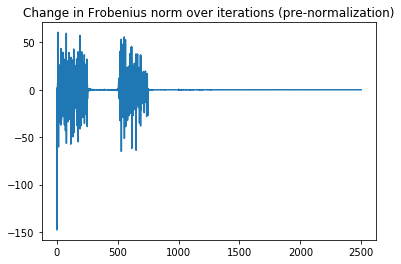

In [8]:
plt.plot(fnorm_record)
plt.title("Change in Frobenius norm over iterations (pre-normalization)")
plt.show()

In the above, convergence of SGD is measured by change in Frobenius norm of pre-normalization codebooks. As can be seen above, while there was huge oscillation in the earlier stage of iteration, it quickly converged after $\approx800$ iterations, resulting in Frobenius norm differences very close to zero thereafter. (i.e. took about 800 to 900 iterations for convergence)

Initial codebook


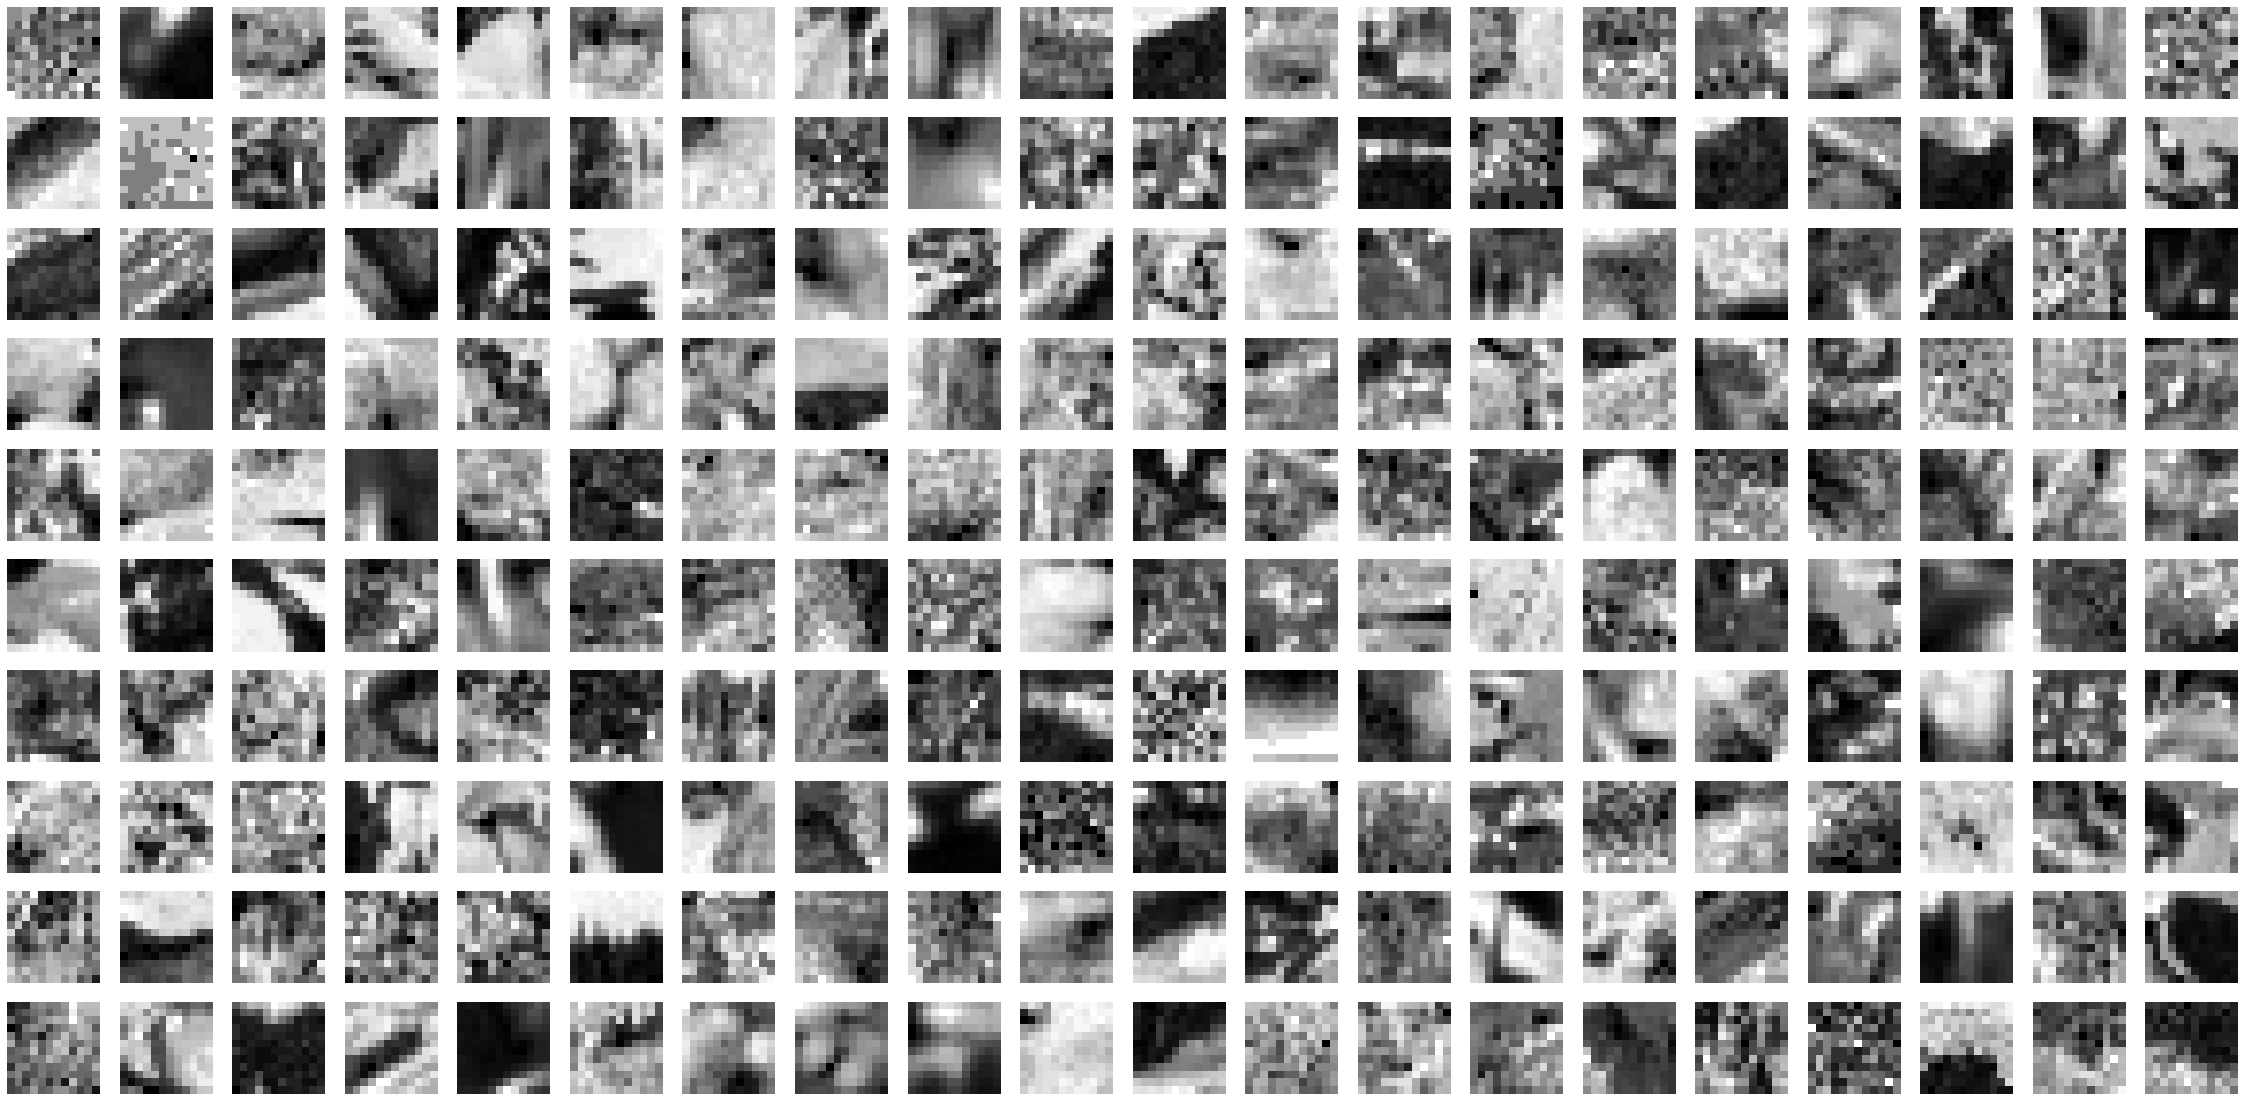

Codebook after 100 iterations


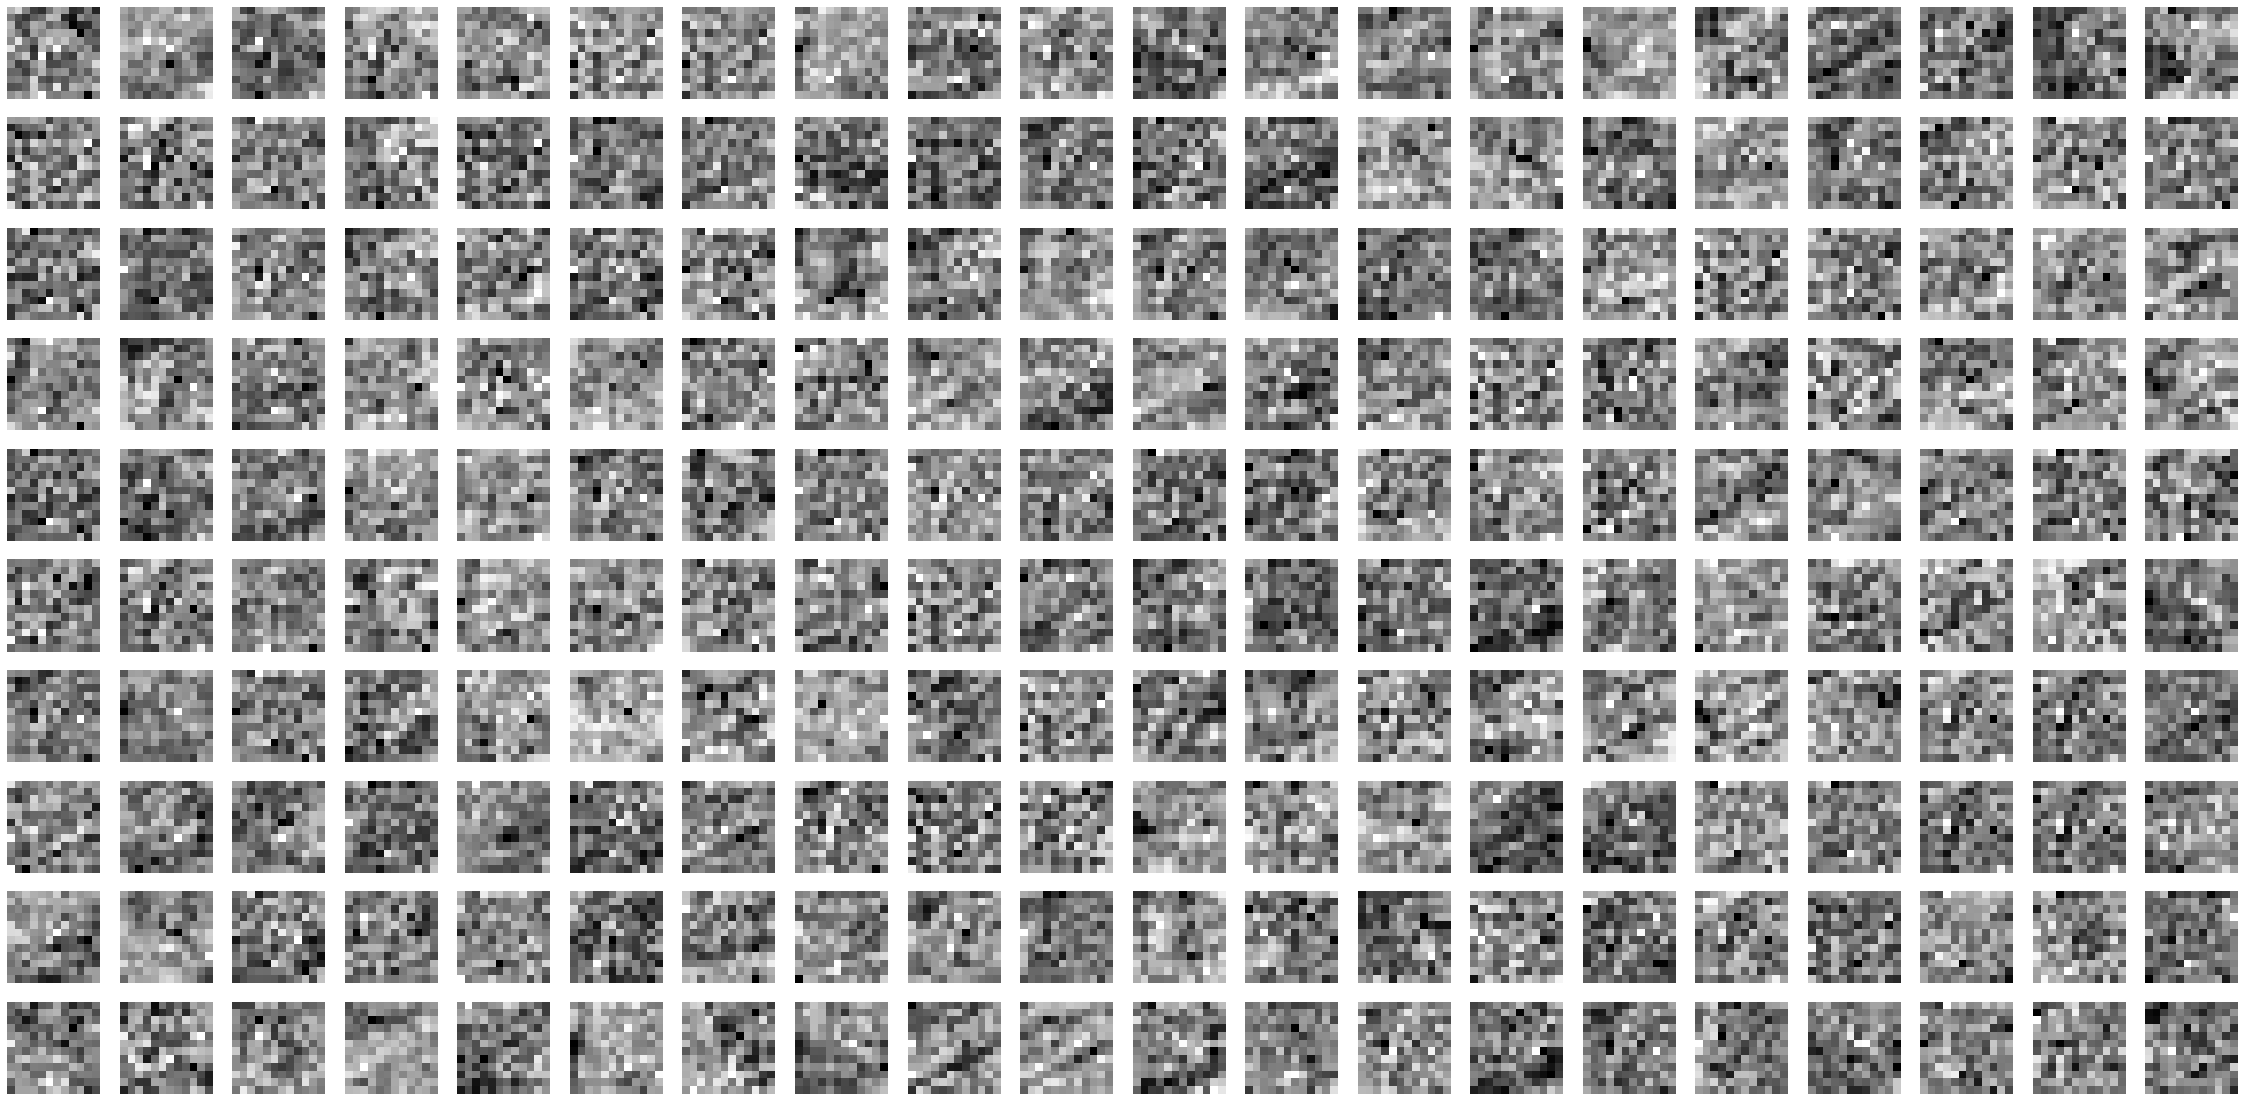

Codebook after 500 iterations


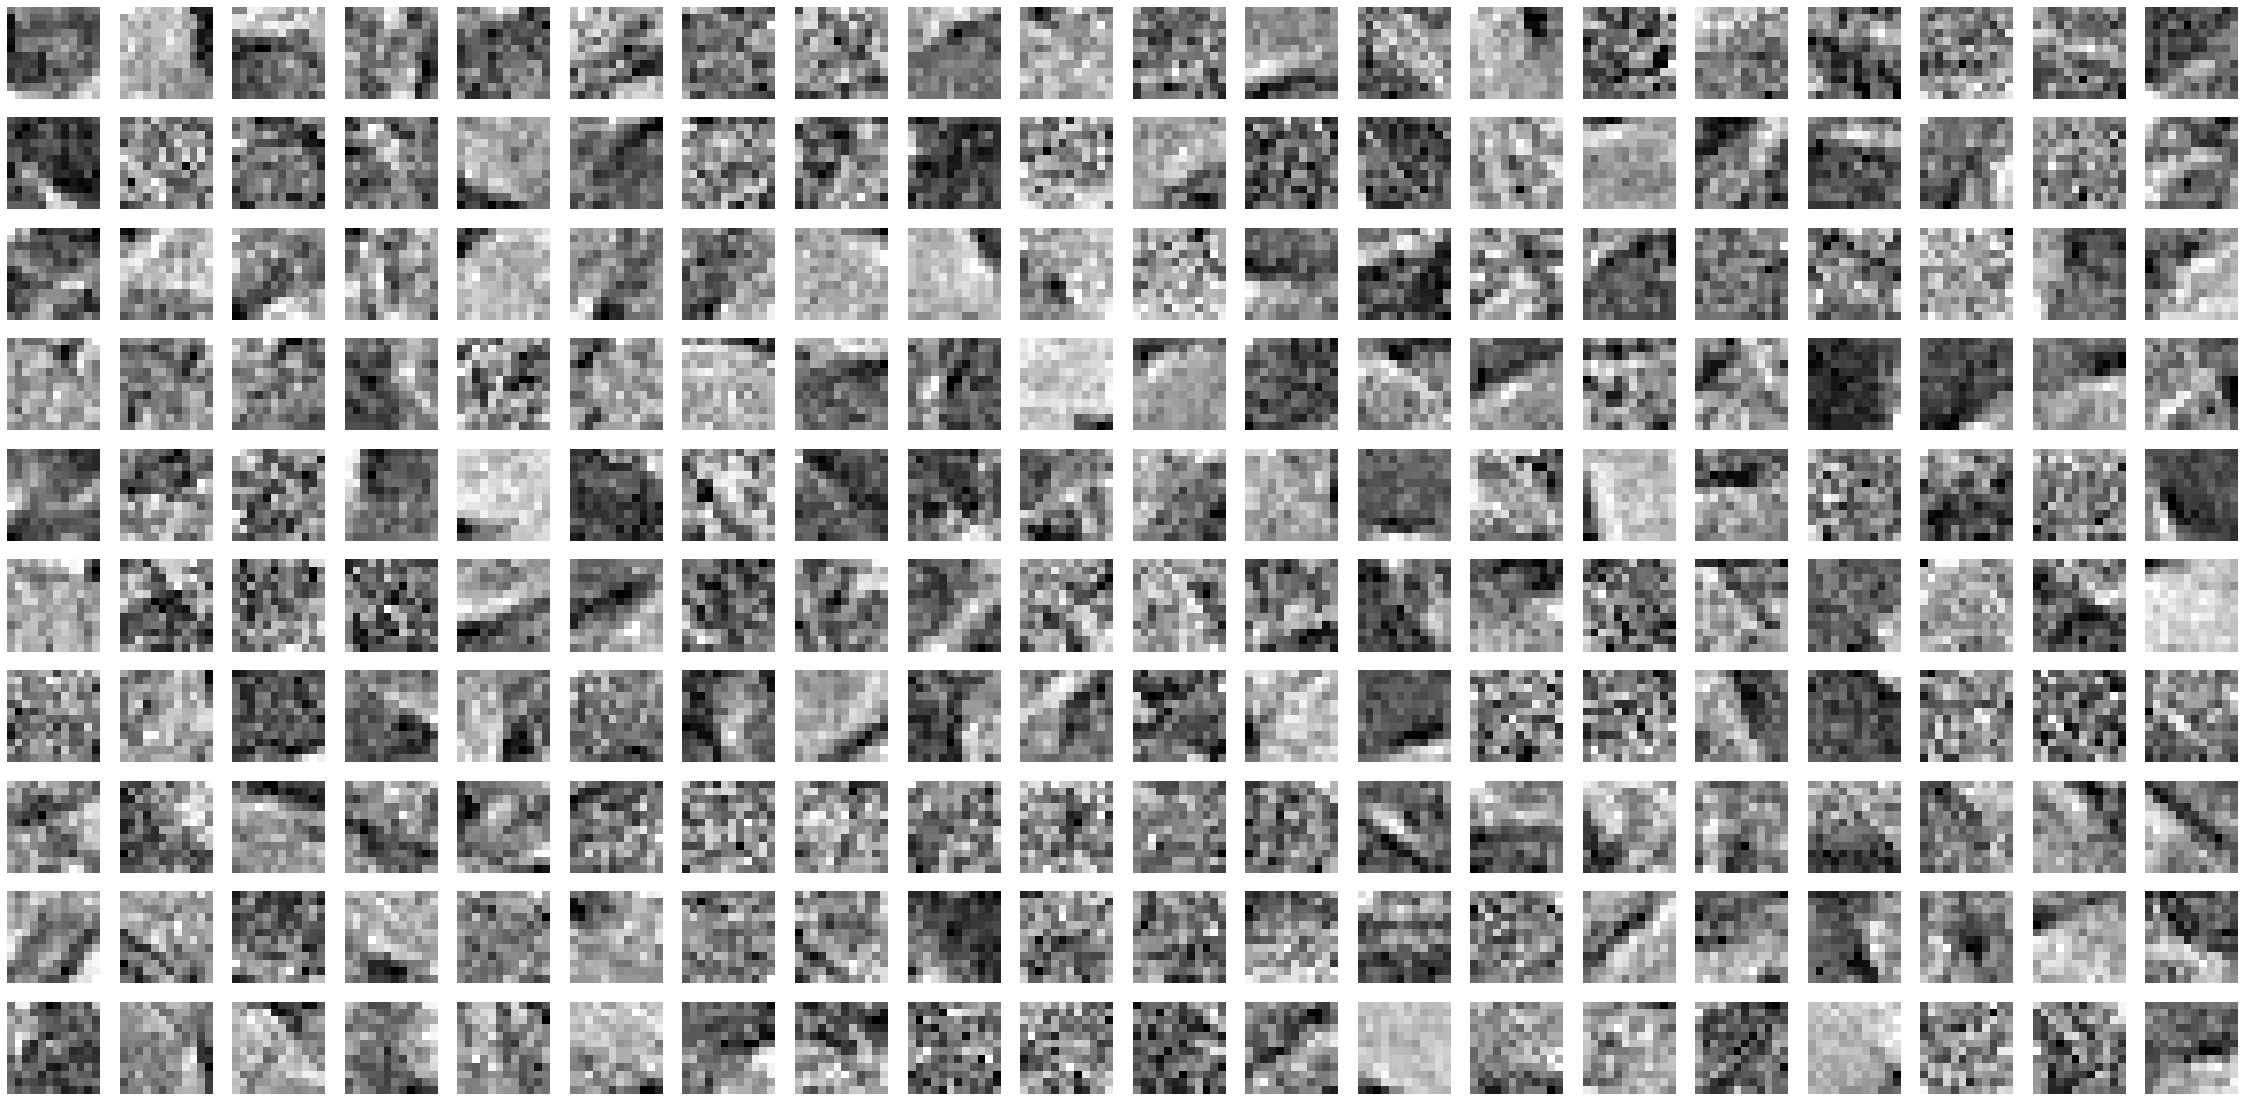

Codebook after 1000 iterations


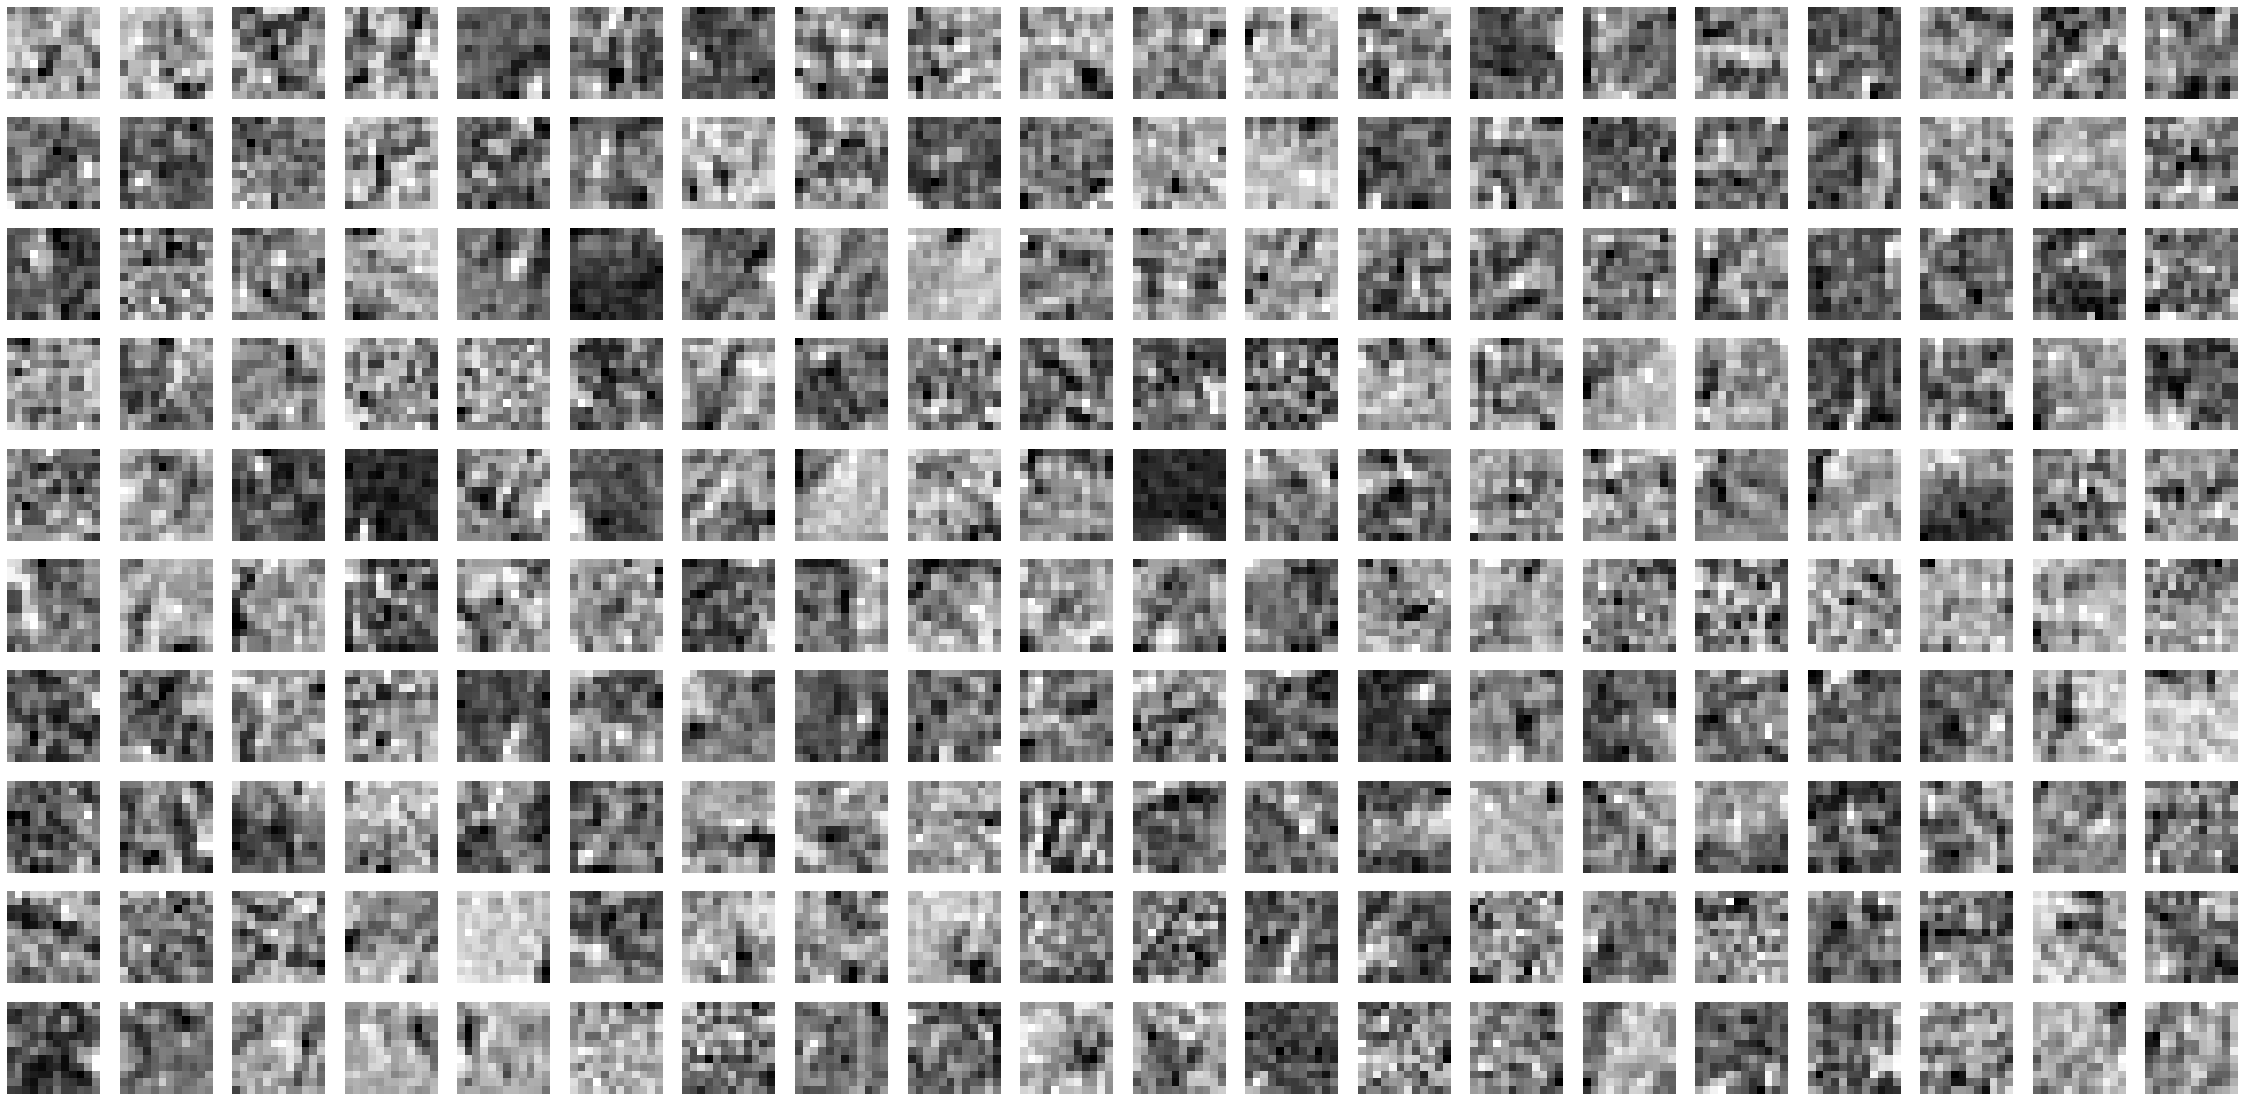

Codebook after 2000 iterations


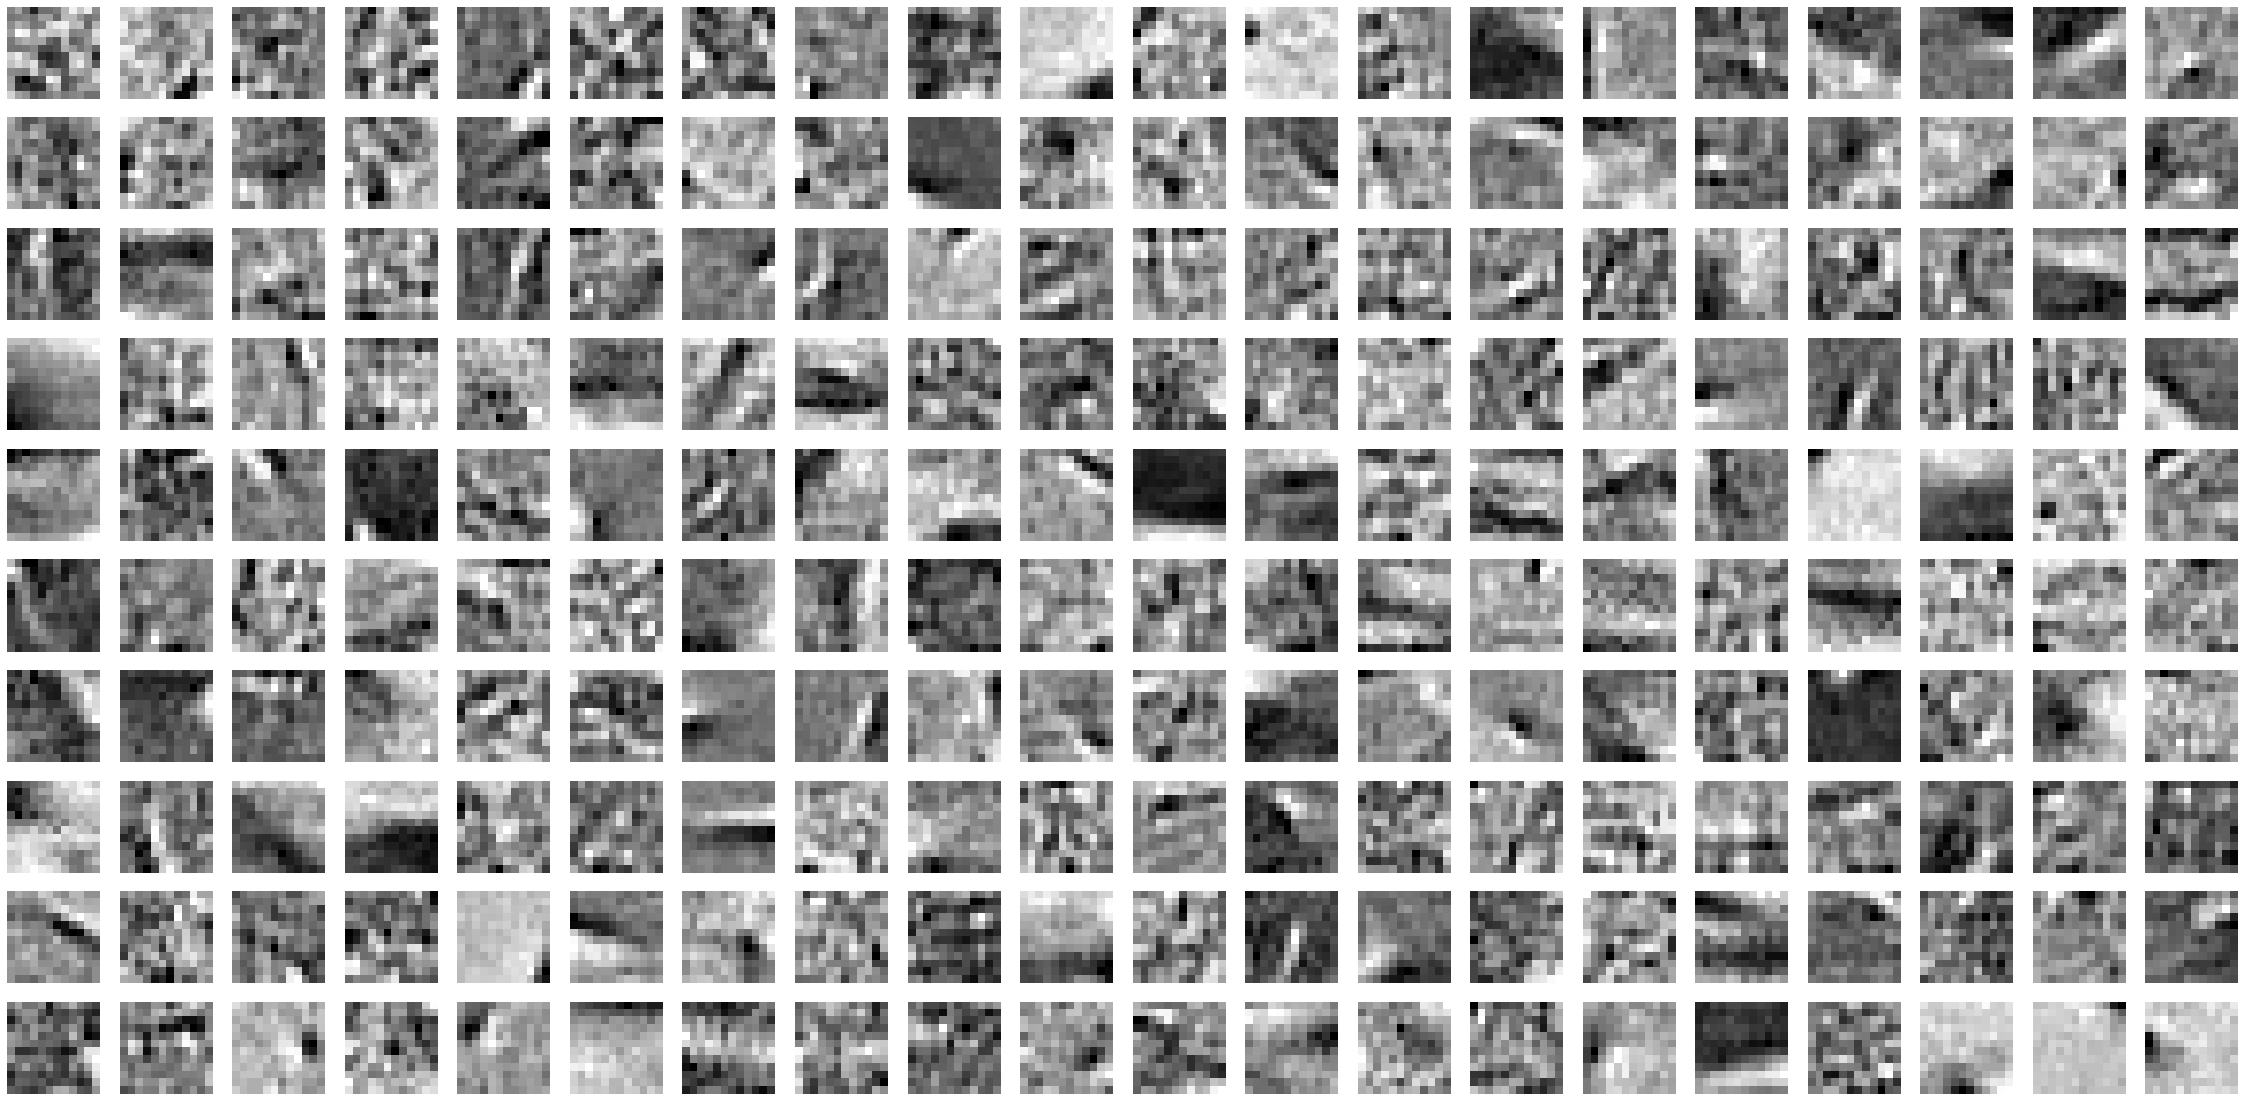

Final codebook


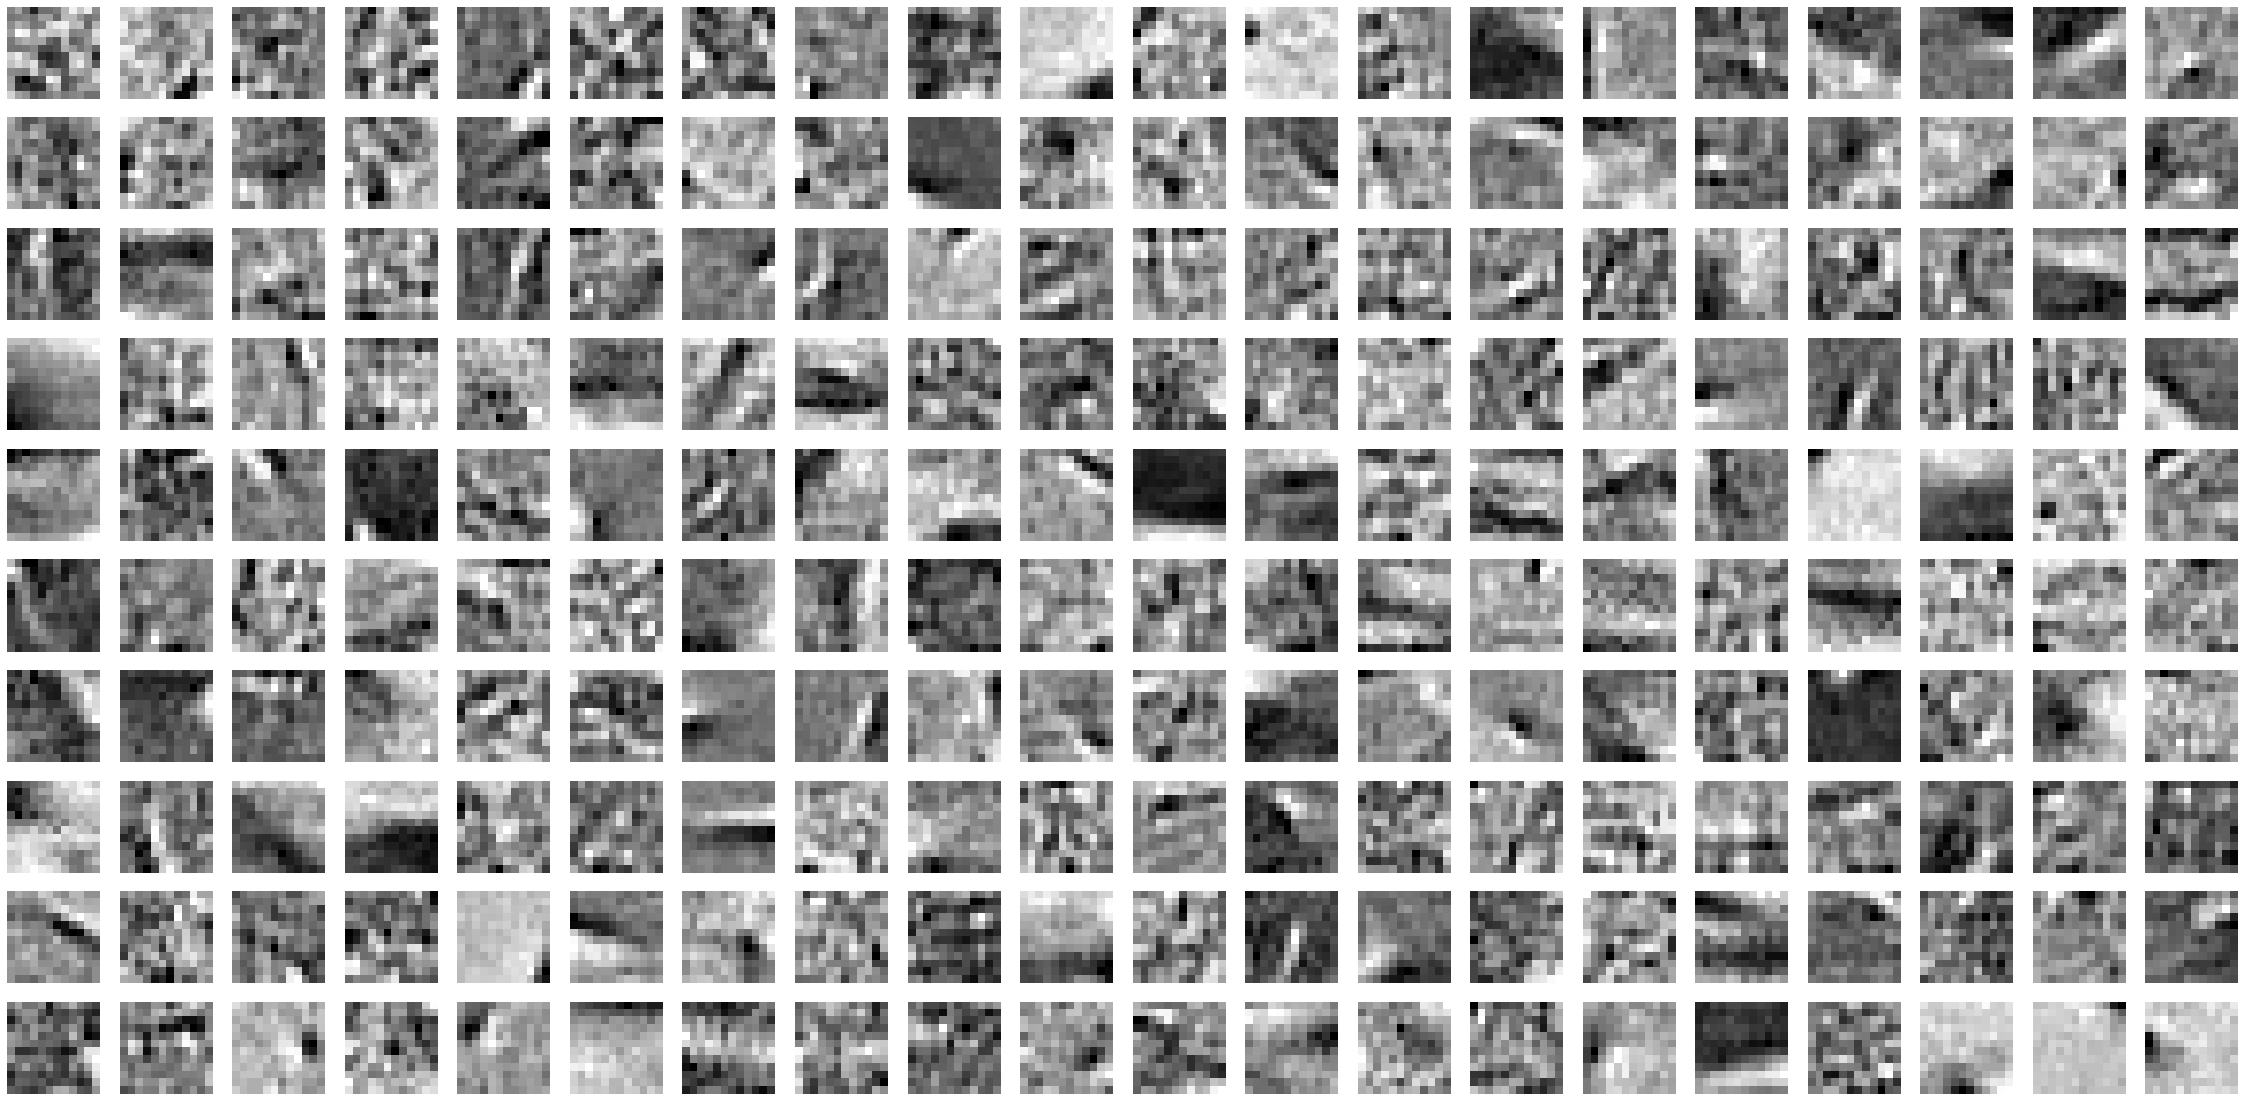

In [9]:
print("Initial codebook")
multiple_plot(codebook_record[0], 10, 20)
print("Codebook after 100 iterations")
multiple_plot(codebook_record[100], 10, 20)
print("Codebook after 500 iterations")
multiple_plot(codebook_record[500], 10, 20)
print("Codebook after 1000 iterations")
multiple_plot(codebook_record[1000], 10, 20)
print("Codebook after 2000 iterations")
multiple_plot(codebook_record[2500], 10, 20)
print("Final codebook")
multiple_plot(codebook_record[-1], 10, 20)

Each patch of the initial codebook obviously contains clear visual characteristics, as they are directly extracted from raw images.  
In the earlier part of iteration (100th update), the codebook seems very noisy and does not contain much information. As we iterate more times and reach the final codebook (after 2500th update), however, those patches seemingly contain more features (in terms of colors, spatial separation, lines, curves, etc.) despite still-lingering noises. (Although $VA$, not $V$ itself, is the approximation of the images, it is still meaningful to know that the codebook is "capturing something.") Also, the 2000th codebook seem to resemble the final one - this is consistent with what we've previously checked: with $\approx2,000$ iterations, the codebook have already achieved convergence.

Overall, I determine that these results are in decent consistency with the paper, in the sense that large number of iterations yielded convergence and better-working codebook. Although the authors of the paper used different rules for parameters and greater number of iterations ($\approx4,000$ updates), above graph and codebooks still seem to be a nice reproduction of the paper's conclusion with smaller number of iterations.

**Part (d):**

Here, I randomly sampled 50 patches (5 from each image) and the final codebook from the SGD executed above. Each codebook vector is multiplied by newly computed $\alpha$'s in order to approximate the original image.

In [10]:
sample_patches = np.zeros([144, 50])

for i in range(10):
    sample = sample_random_square_patches(images[:, :, i], 5, 12)
    sample_patches[:, i * 5:i * 5 + 5] = sample

In [11]:
test_codebook = codebook_record[-1]
test_lasso = Lasso(fit_intercept = False, copy_X = True, alpha = 0.001)
test_alpha = test_lasso.fit(test_codebook, sample_patches).coef_.T

Original sample patches


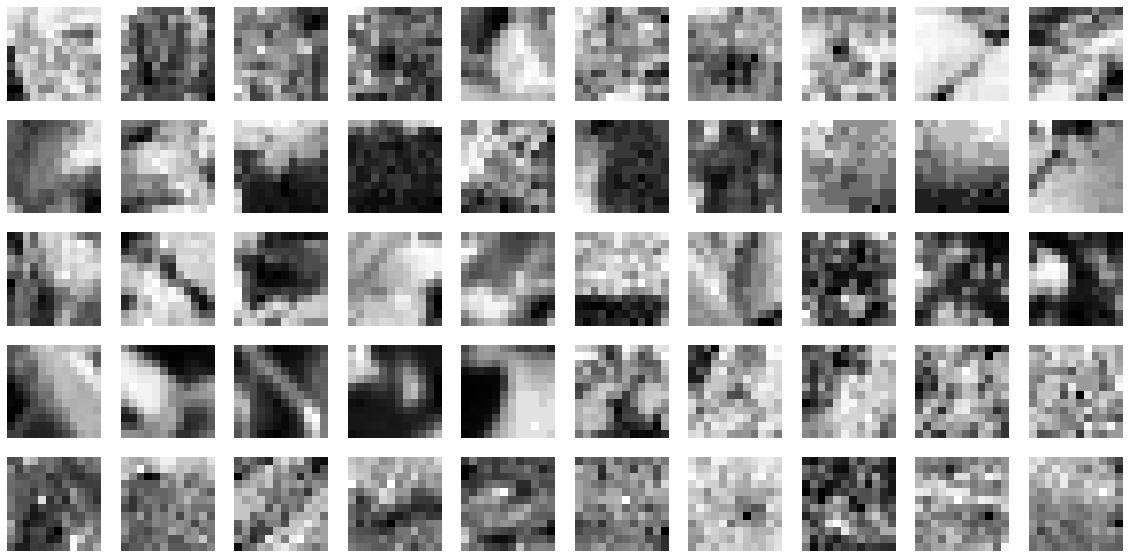

Reconstructed patches


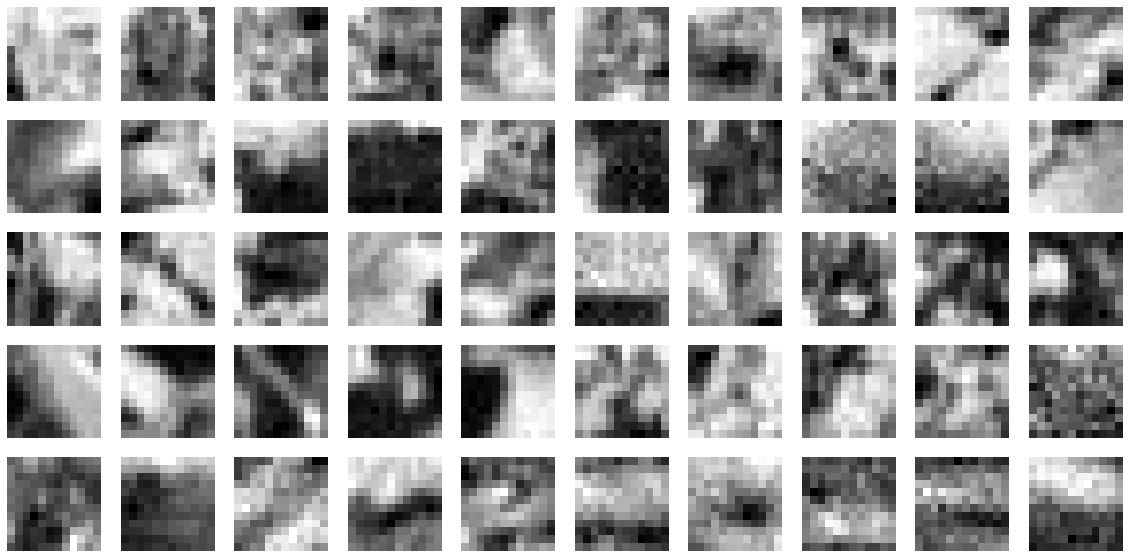

In [12]:
reconstruct = np.matmul(test_codebook, test_alpha)
reconstruct = np.reshape(reconstruct, (12, 12, 50))

print("Original sample patches")
multiple_plot(np.reshape(sample_patches, (12, 12, 50)), 5, 10)

print("Reconstructed patches")
multiple_plot(reconstruct, 5, 10)

These reconstructions seem to be good approximation of the original patches. In particular, there are doing nice job capturing black-white gradation, spatial separation within each image, visually recognizable patterns (such as dots), lines and curves (with directions and curvatures), etc., even though they are not the perfect replication of those patches when we look into fine details.  
Some of the best examples of capturing raw image features, I think, are: 9the and 10th ones on the first row, 10th one on the third row, and the 3rd one on the fourth row. On the other hand, for some patches, it is hard to determine whether $VA$ successfully approximated the original since the original samples themselves were quite blurry (e.g. 6th one on the first row).